# Reading in GridRad-Severe Data Part 2: Velocity Spectrum Width and Correlation Coefficient 

## Overview

In the last notebook, we read in and analyzed radar reflectivity and azimuthal shear data from GridRad-Severe with the May 4, 2018 NH tornado and the July 29, 2021 PA/NJ tornado. In this follow-up notebook, we will look at a couple more helpful GR-S variables, the velocity spectrum width and correlation coefficient, once again centered around these events. 

1. Prerequisites
2. Imports
3. Content
4. Summary
5. Conclusions
6. Resources and References

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Numpy](https://foundations.projectpythia.org/core/numpy/) | Necessary | |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy) | Necessary | |
| [Intro to Pandas](https://foundations.projectpythia.org/core/pandas/) | Necessary | |
| [Understanding of Xarray](https://foundations.projectpythia.org/core/xarray/) | Helpful | Analysis of gridded datasets |
| [Understanding of Matplotlib](https://foundations.projectpythia.org/core/matplotlib/) | Helpful | Creating plots in Python |
| [Using Gridradpy Library](https://github.com/tsupinie/gridradpy) | Helpful | Specifically load in and use GridRad data | 

- **Time to learn**: About 1 hour (10 minutes per subsection)

:::{note}
In this notebook, I use a lot of the same code and data that I used in the previous notebook, so this one will not contain as much notes as the notes I wrote in Notebook 1 also apply here. 
:::

## Imports

As always, we will start off my importing any relevant datasets we will need in this notebook. We use the xarray, numpy, cartopy, matplotlib and pandas packages like in the last notebook. 

In [20]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import pandas as pd 

## Content #1: Plotting the Velocity Spectrum Width from GR-S 

Another data variable that GR-S contains is the Velocity Spectrum Width, or the measure of the speed and direction of particles within a volume of air, detected by Doppler radar. This is very useful for detecting turbulence in severe thunderstorms and supercells and identifying the location of tornadoes or gust fronts. We will once again plot frames of this data for both severe weather events and then make animations of that. 

We of course need to read and load in the GR-S NEXRAD radar files like we did before. 

In [21]:
file_path = '/nfs/mulholland_lab/acolgate/Research/2018/2018/nexrad_3d_v4_2_20180505T012000Z.nc' 
ds = xr.open_dataset(file_path)
ds

<xarray.Dataset> Size: 79MB
Dimensions:                    (Sweep: 417, Altitude: 29, Latitude: 576,
                                Longitude: 576, Index: 1000794, time: 1)
Coordinates:
  * Altitude                   (Altitude) float64 232B 0.5 1.0 1.5 ... 21.0 22.0
  * Latitude                   (Latitude) float64 5kB 36.01 36.03 ... 47.99
  * Longitude                  (Longitude) float64 5kB 278.0 278.0 ... 290.0
  * time                       (time) datetime64[ns] 8B 2018-05-05T01:20:00
Dimensions without coordinates: Sweep, Index
Data variables: (12/18)
    sweeps_merged              (Sweep) |S29 12kB ...
    Nradobs                    (Altitude, Latitude, Longitude) int8 10MB ...
    Nradecho                   (Altitude, Latitude, Longitude) int8 10MB ...
    index                      (Index) int32 4MB ...
    Reflectivity               (Index) float32 4MB ...
    wReflectivity              (Index) float32 4MB ...
    ...                         ...
    DifferentialReflectivity   (Index) float32 4MB ...
    wDifferentialReflectivity  (Index) float32 4MB ...
    DifferentialPhase          (Index) float32 4MB ...
    wDifferentialPhase         (Index) float32 4MB ...
    CorrelationCoefficient     (Index) float32 4MB ...
    wCorrelationCoefficient    (Index) float32 4MB ...
Attributes: (12/16)
    Name:                   GridRad
    Description:            Three-dimensional gridded NEXRAD radar reflectivi...
    Analysis_time:          2018-05-05 01:20:00Z
    Analysis_time_window:   all azimuth scans (elevation angles) with central...
    Algorithm_version:      v4_2
    Algorithm_description:  Space and time binning weighted by distances from...
    ...                     ...
    Storage_scheme:         netCDF-4, sparse
    Data_source:            Amazon Web Services
    Data_source_URL:        https://www.ncdc.noaa.gov/data-access/radar-data/...
    Authors:                Cameron R. Homeyer, School of Meteorology, Univer...
    Project_sponsor:        National Oceanic and Atmospheric Administration, ...
    Project_name:           0-3 Hour Tornado Prediction Using the Warn on For...

In [22]:
lon_vals = ds['Longitude'].values
lat_vals = ds['Latitude'].values
alt_vals = ds['Altitude'].values

nlon, nlat, nalt = len(lon_vals), len(lat_vals), len(alt_vals)

spec_grid = np.full((nalt, nlat, nlon), np.nan, dtype=np.float32)

index = ds['index'].values
spec = ds['SpectrumWidth'].values

k = index // (nlat * nlon)
j = (index % (nlat * nlon)) // nlon
i = index % nlon

spec_grid[k, j, i] = spec

colmax_spec = np.nanmax(spec_grid, axis=0)
colmax_spec = np.squeeze(colmax_spec)

/tmp/ipykernel_2738309/3990426621.py:18: RuntimeWarning: All-NaN slice encountered
  colmax_spec = np.nanmax(spec_grid, axis=0)


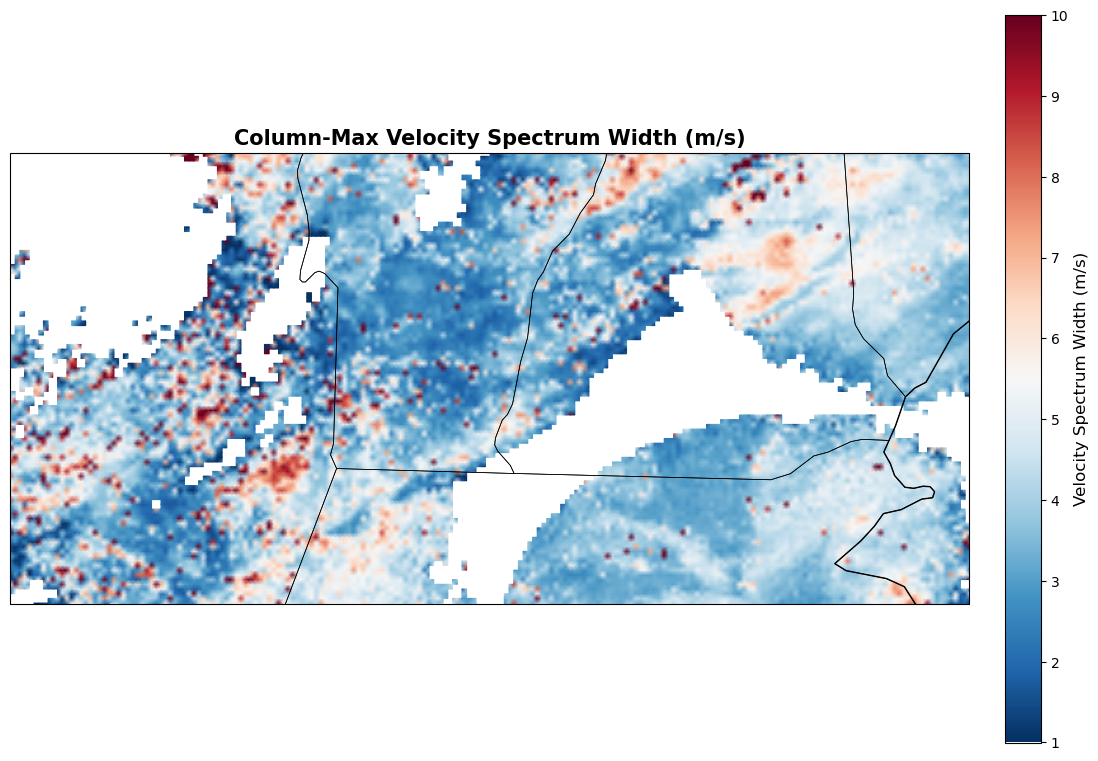

In [23]:
lon_grid, lat_grid = np.meshgrid(lon_vals, lat_vals)

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 10))

pcm = ax.pcolormesh(
    lon_grid, lat_grid, colmax_spec,
    cmap='RdBu_r',          
    vmin=1, vmax=10,  
    shading='gouraud',     
    transform=ccrs.PlateCarree()
)

ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5)
ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=0.7)
ax.coastlines(resolution='50m')

extent = [-70.45, -74.7, 42.15, 44.15]
ax.set_extent(extent, crs=ccrs.PlateCarree())

cbar = plt.colorbar(pcm, ax=ax, orientation='vertical', shrink=0.75, pad=0.03)
cbar.set_label("Velocity Spectrum Width (m/s)", fontsize=12)
cbar.ax.tick_params(labelsize=10)

ax.set_title("Column-Max Velocity Spectrum Width (m/s)", fontsize=15, weight='bold')
plt.tight_layout()
plt.show()

While there is a bit of noise on this graph, you cna make out some relatively higher areas of velocity spectrum width in southwestern NH where the squall line and resultant tornadic couplet were moving through. 

Next, let's do the same thing with the July 29th event. 

In [24]:
file_path2 = '/nfs/mulholland_lab/acolgate/Research/2021/2021/nexrad_3d_v4_2_20210729T220500Z.nc' 
ds2 = xr.open_dataset(file_path2)
print(ds2)

<xarray.Dataset> Size: 79MB
Dimensions:                    (Sweep: 733, Altitude: 29, Latitude: 624,
                                Longitude: 576, Index: 972593, time: 1)
Coordinates:
  * Altitude                   (Altitude) float64 232B 0.5 1.0 1.5 ... 21.0 22.0
  * Latitude                   (Latitude) float64 5kB 33.01 33.03 ... 45.99
  * Longitude                  (Longitude) float64 5kB 274.0 274.0 ... 286.0
  * time                       (time) datetime64[ns] 8B 2021-07-29T22:05:00
Dimensions without coordinates: Sweep, Index
Data variables: (12/18)
    sweeps_merged              (Sweep) |S29 21kB ...
    Nradobs                    (Altitude, Latitude, Longitude) int8 10MB ...
    Nradecho                   (Altitude, Latitude, Longitude) int8 10MB ...
    index                      (Index) int32 4MB ...
    Reflectivity               (Index) float32 4MB ...
    wReflectivity              (Index) float32 4MB ...
    ...                         ...
    DifferentialReflectivity 

In [25]:
lon_vals2 = ds2['Longitude'].values
lat_vals2 = ds2['Latitude'].values
alt_vals2 = ds2['Altitude'].values

nlon2, nlat2, nalt2 = len(lon_vals2), len(lat_vals2), len(alt_vals2)
spec_grid2 = np.full((nalt2, nlat2, nlon2), np.nan, dtype=np.float32)

index2 = ds2['index'].values
spec2 = ds2['SpectrumWidth'].values

k2 = index2 // (nlat2 * nlon2)
j2 = (index2 % (nlat2 * nlon2)) // nlon2
i2 = index2 % nlon2

spec_grid2[k2, j2, i2] = spec2

colmax_spec2 = np.nanmax(spec_grid2, axis=0)
colmax_spec2 = np.squeeze(colmax_spec2)

/tmp/ipykernel_2738309/3936111627.py:17: RuntimeWarning: All-NaN slice encountered
  colmax_spec2 = np.nanmax(spec_grid2, axis=0)


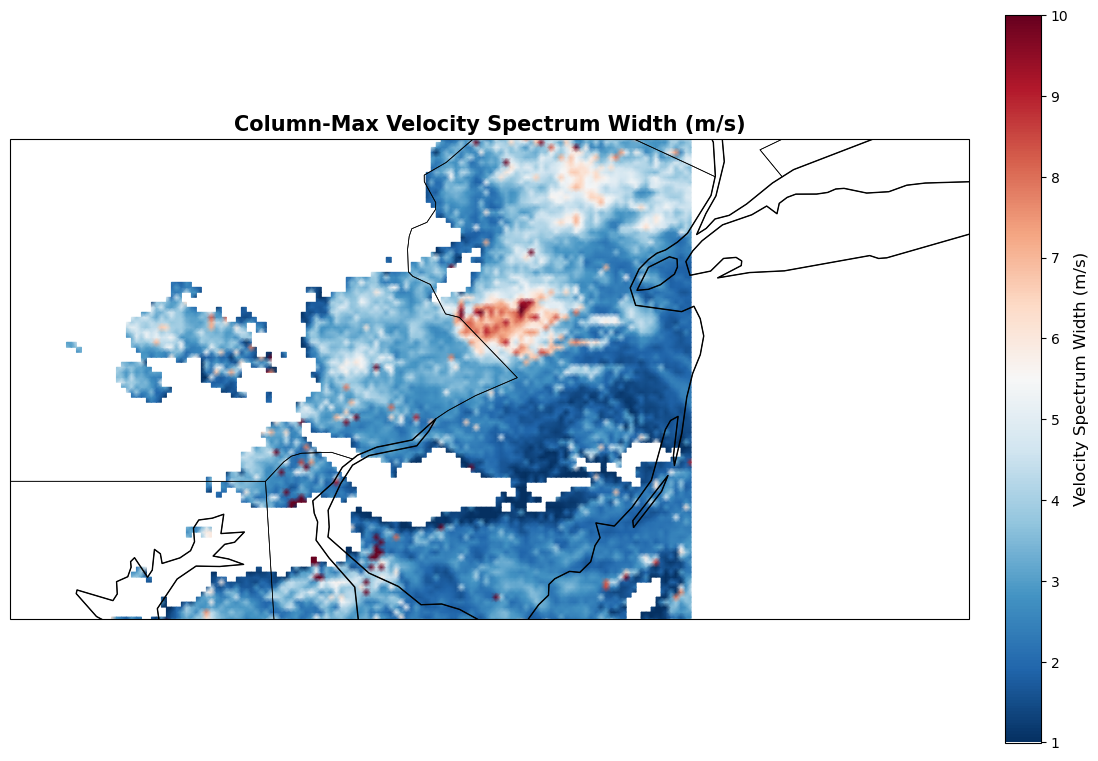

In [26]:
lon_grid2, lat_grid2 = np.meshgrid(lon_vals2, lat_vals2)

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 10))

pcm = ax.pcolormesh(
    lon_grid2, lat_grid2, colmax_spec2,
    cmap='RdBu_r',          
    vmin=1, vmax=10,  
    shading='gouraud',     
    transform=ccrs.PlateCarree()
)

ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5)
ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=0.7)
ax.coastlines(resolution='50m')

extent2 = [-72.85, -76.85, 39.15, 41.15]
ax.set_extent(extent2, crs=ccrs.PlateCarree())

cbar = plt.colorbar(pcm, ax=ax, orientation='vertical', shrink=0.75, pad=0.03)
cbar.set_label("Velocity Spectrum Width (m/s)", fontsize=12)
cbar.ax.tick_params(labelsize=10)

ax.set_title("Column-Max Velocity Spectrum Width (m/s)", fontsize=15, weight='bold')
plt.tight_layout()
plt.show()

This graph is a lot clearer in showing the strong turbulence and movement of air particles with the supercell along the NJ/PA border. 

## Content #2: Plotting GR-S Correlation Coefficient Data 

Lastly, we can look at the Correlation Coefficient (CC) data from GR-S. CC is a common data variable measured in dual-polarization radar products to measure shapes and sizes of objects in the atmosphere. Values closer to 1 (high values) represent rain or snow, while values closer to 0 (low values) can represent debris, melting snow or hail. This helps meteorologists identify phenomena such as tornadic debris, which is very important for live-tracking of tornadic supercells.  

In [27]:
lon_vals3 = ds['Longitude'].values
lat_vals3 = ds['Latitude'].values
alt_vals3 = ds['Altitude'].values

nlon3, nlat3, nalt3 = len(lon_vals3), len(lat_vals3), len(alt_vals3)

coeff_grid = np.full((nalt3, nlat3, nlon3), np.nan, dtype=np.float32)

index3 = ds['index'].values
coeff = ds['CorrelationCoefficient'].values

k3 = index3 // (nlat3 * nlon3)
j3 = (index3 % (nlat3 * nlon3)) // nlon3
i3 = index3 % nlon3

coeff_grid[k3, j3, i3] = coeff

colmax_coeff = np.nanmax(coeff_grid, axis=0)
colmax_coeff = np.squeeze(colmax_coeff)

/tmp/ipykernel_2738309/2293036275.py:18: RuntimeWarning: All-NaN slice encountered
  colmax_coeff = np.nanmax(coeff_grid, axis=0)


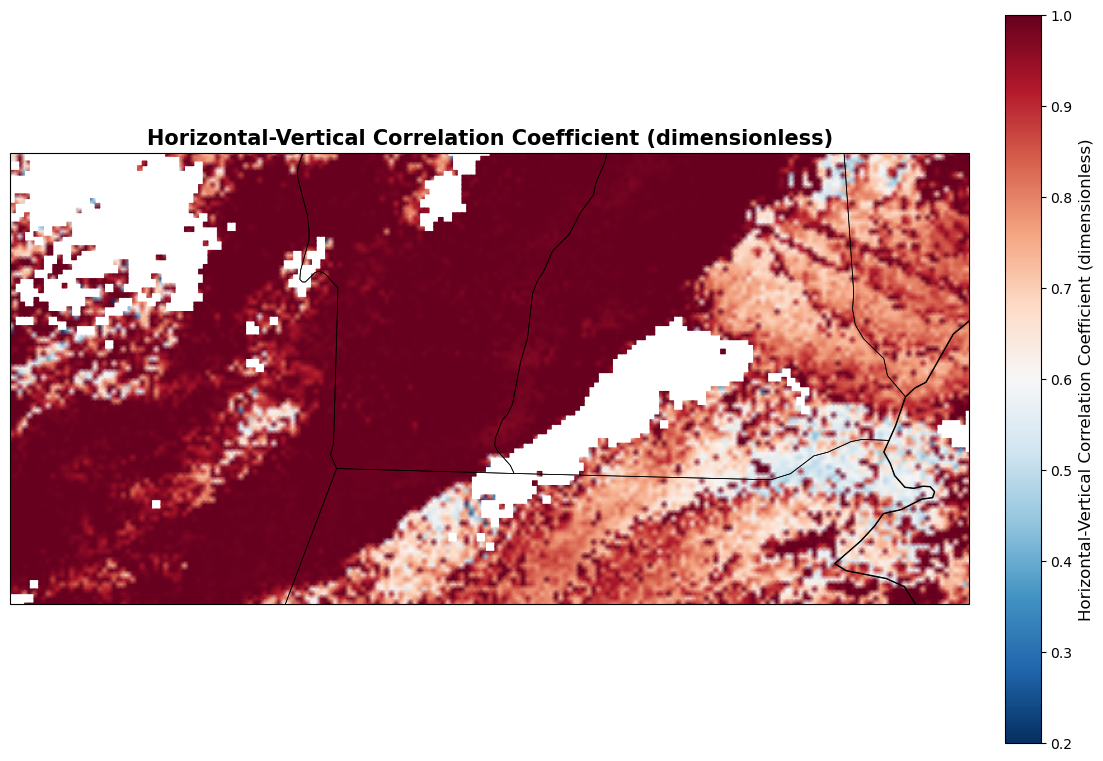

In [28]:
lon_grid3, lat_grid3 = np.meshgrid(lon_vals3, lat_vals3)

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 10))

pcm = ax.pcolormesh(
    lon_grid3, lat_grid3, colmax_coeff,
    cmap='RdBu_r',          
    vmin=0.2, vmax=1.0,  
    shading='gouraud',     
    transform=ccrs.PlateCarree()
)

ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5)
ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=0.7)
ax.coastlines(resolution='50m')

extent = [-70.45, -74.7, 42.15, 44.15]
ax.set_extent(extent, crs=ccrs.PlateCarree())

cbar = plt.colorbar(pcm, ax=ax, orientation='vertical', shrink=0.75, pad=0.03)
cbar.set_label("Horizontal-Vertical Correlation Coefficient (dimensionless)", fontsize=12)
cbar.ax.tick_params(labelsize=10)

ax.set_title("Horizontal-Vertical Correlation Coefficient (dimensionless)", fontsize=15, weight='bold')
plt.tight_layout()
plt.show()

There is some slightly lighter coloring around the storm couplet in southwest NH, but it is hard to make out any distinct gaps in the data or debris signatures that would represent a tornado on the ground here. Let's do this with the 7/29 supercell to see if that event would be a bit clearer to study. 

In [29]:
lon_vals4 = ds2['Longitude'].values
lat_vals4 = ds2['Latitude'].values
alt_vals4 = ds2['Altitude'].values

nlon4, nlat4, nalt4 = len(lon_vals4), len(lat_vals4), len(alt_vals4)

coeff_grid2 = np.full((nalt4, nlat4, nlon4), np.nan, dtype=np.float32)

index4 = ds2['index'].values
coeff2 = ds2['CorrelationCoefficient'].values

k4 = index4 // (nlat4 * nlon4)
j4 = (index4 % (nlat4 * nlon4)) // nlon4
i4 = index4 % nlon4

coeff_grid2[k4, j4, i4] = coeff2

colmax_coeff2 = np.nanmax(coeff_grid2, axis=0)
colmax_coeff2 = np.squeeze(colmax_coeff2)

/tmp/ipykernel_2738309/608759967.py:18: RuntimeWarning: All-NaN slice encountered
  colmax_coeff2 = np.nanmax(coeff_grid2, axis=0)


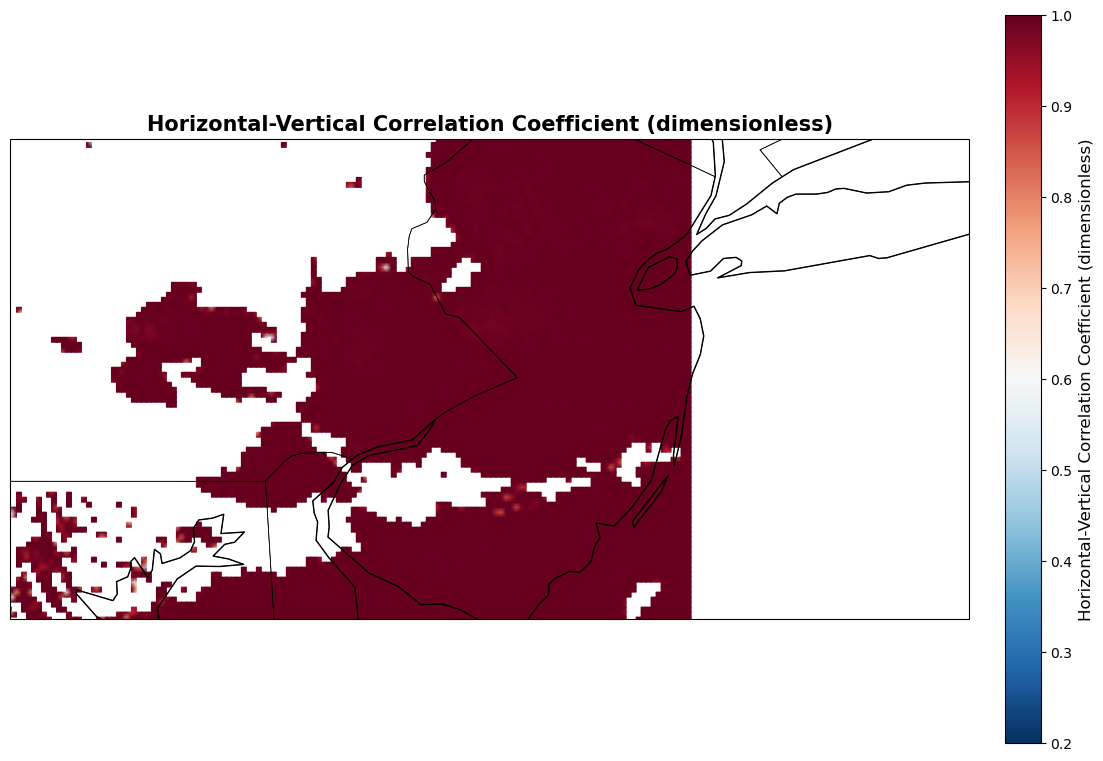

In [30]:
lon_grid4, lat_grid4 = np.meshgrid(lon_vals4, lat_vals4)

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 10))

pcm = ax.pcolormesh(
    lon_grid4, lat_grid4, colmax_coeff2,
    cmap='RdBu_r',          
    vmin=0.2, vmax=1.0,  
    shading='gouraud',     
    transform=ccrs.PlateCarree()
)

ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5)
ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=0.7)
ax.coastlines(resolution='50m')

extent2 = [-72.85, -76.85, 39.15, 41.15]
ax.set_extent(extent2, crs=ccrs.PlateCarree())

cbar = plt.colorbar(pcm, ax=ax, orientation='vertical', shrink=0.75, pad=0.03)
cbar.set_label("Horizontal-Vertical Correlation Coefficient (dimensionless)", fontsize=12)
cbar.ax.tick_params(labelsize=10)

ax.set_title("Horizontal-Vertical Correlation Coefficient (dimensionless)", fontsize=15, weight='bold')
plt.tight_layout()
plt.show()

It is again hard to make out anything meaningful here, but the dots in the data along the PA/NJ border might represent the debris signature from the tornado. This might show that the CC data might not be a strong suit of GR-S, and it would be better to look at other variables.

# Content #3: Making Animations of Velocity Spectrum Width and CC

Of course, we can make animations of these data variables to study how they evolve over time, just like we did in Notebook 1. We will start with the VSW. Since the 7/29 supercell is a bit more well-defined, I think it would be best to study this data only with that severe event. 

In [31]:
import glob
from matplotlib.animation import FuncAnimation

def decode_gridrad_spectrumwidth(ds2):
    """
    Decode sparse GridRad reflectivity (v4.2) to full 3D reflectivity array.
    Returns array with shape:
        (Altitude, Latitude, Longitude)
    """

    nz = ds2["Altitude"].size
    ny = ds2["Latitude"].size
    nx = ds2["Longitude"].size

    # Initializing full grid 
    Z = np.full((nz, ny, nx), np.nan, dtype=np.float32)

    # Sparse arrays
    velo = ds2["SpectrumWidth"].values  
    idx  = ds2["index"].values.astype(np.int64)

    plane_size = ny * nx
    
    alt = idx // plane_size
    rem = idx % plane_size
    lat = rem // nx
    lon = rem % nx

    # Fill grid
    Z[alt, lat, lon] = velo

    return Z

In [32]:
nc_files2 = sorted(glob.glob("/nfs/mulholland_lab/acolgate/Research/2021/2021/nexrad_3d_v4_2_20210729T*.nc"))

colmax_list = []
times = []

print(f"Found {len(nc_files2)} GridRad files")

for f in nc_files2:
    print("Processing:", f)
    ds = xr.open_dataset(f)

    Z_spec = decode_gridrad_spectrumwidth(ds)

    # Column-max spectrum width 
    colmax = np.nanmax(Z_spec, axis=0)   
    colmax_list.append(colmax)

    # Store timestamp
    time_string = str(ds["time"].values[0])  # Pull timestamp from the dataset and add it to 'times' list 
    ts = pd.to_datetime(time_string)
    ts = ts.tz_localize('UTC')
    utc_ts = ts.tz_convert("UTC")
    time_format = f"{utc_ts.strftime('%Y-%m-%d %H:%M:%S %Z')}"
    times.append(str(time_format))

# Stack into array (Time, Lat, Lon)
colmax_array = np.stack(colmax_list)

# Coordinates
lats = ds2["Latitude"].values
lons = ds2["Longitude"].values
lon_grid, lat_grid = np.meshgrid(lons, lats)

Found 11 GridRad files
Processing: /nfs/mulholland_lab/acolgate/Research/2021/2021/nexrad_3d_v4_2_20210729T214000Z.nc


/tmp/ipykernel_2738309/3239839890.py:15: RuntimeWarning: All-NaN slice encountered
  colmax = np.nanmax(Z_spec, axis=0)


Processing: /nfs/mulholland_lab/acolgate/Research/2021/2021/nexrad_3d_v4_2_20210729T214500Z.nc


/tmp/ipykernel_2738309/3239839890.py:15: RuntimeWarning: All-NaN slice encountered
  colmax = np.nanmax(Z_spec, axis=0)


Processing: /nfs/mulholland_lab/acolgate/Research/2021/2021/nexrad_3d_v4_2_20210729T215000Z.nc


/tmp/ipykernel_2738309/3239839890.py:15: RuntimeWarning: All-NaN slice encountered
  colmax = np.nanmax(Z_spec, axis=0)


Processing: /nfs/mulholland_lab/acolgate/Research/2021/2021/nexrad_3d_v4_2_20210729T215500Z.nc


/tmp/ipykernel_2738309/3239839890.py:15: RuntimeWarning: All-NaN slice encountered
  colmax = np.nanmax(Z_spec, axis=0)


Processing: /nfs/mulholland_lab/acolgate/Research/2021/2021/nexrad_3d_v4_2_20210729T220000Z.nc


/tmp/ipykernel_2738309/3239839890.py:15: RuntimeWarning: All-NaN slice encountered
  colmax = np.nanmax(Z_spec, axis=0)
/tmp/ipykernel_2738309/3239839890.py:15: RuntimeWarning: All-NaN slice encountered
  colmax = np.nanmax(Z_spec, axis=0)


Processing: /nfs/mulholland_lab/acolgate/Research/2021/2021/nexrad_3d_v4_2_20210729T220500Z.nc
Processing: /nfs/mulholland_lab/acolgate/Research/2021/2021/nexrad_3d_v4_2_20210729T221000Z.nc


/tmp/ipykernel_2738309/3239839890.py:15: RuntimeWarning: All-NaN slice encountered
  colmax = np.nanmax(Z_spec, axis=0)


Processing: /nfs/mulholland_lab/acolgate/Research/2021/2021/nexrad_3d_v4_2_20210729T221500Z.nc


/tmp/ipykernel_2738309/3239839890.py:15: RuntimeWarning: All-NaN slice encountered
  colmax = np.nanmax(Z_spec, axis=0)


Processing: /nfs/mulholland_lab/acolgate/Research/2021/2021/nexrad_3d_v4_2_20210729T222000Z.nc


/tmp/ipykernel_2738309/3239839890.py:15: RuntimeWarning: All-NaN slice encountered
  colmax = np.nanmax(Z_spec, axis=0)


Processing: /nfs/mulholland_lab/acolgate/Research/2021/2021/nexrad_3d_v4_2_20210729T222500Z.nc


/tmp/ipykernel_2738309/3239839890.py:15: RuntimeWarning: All-NaN slice encountered
  colmax = np.nanmax(Z_spec, axis=0)


Processing: /nfs/mulholland_lab/acolgate/Research/2021/2021/nexrad_3d_v4_2_20210729T223000Z.nc


/tmp/ipykernel_2738309/3239839890.py:15: RuntimeWarning: All-NaN slice encountered
  colmax = np.nanmax(Z_spec, axis=0)


In [33]:
fig, ax = plt.subplots(
    figsize=(12, 10),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

# First frame
pcm = ax.pcolormesh(
    lon_grid, lat_grid, np.zeros_like(colmax_array[0]),
    cmap="RdBu_r", vmin=1, vmax=10,
    shading="gouraud",
    transform=ccrs.PlateCarree()
)

# Colorbar
cbar = fig.colorbar(pcm, ax=ax, shrink=0.8, pad=0.02)
cbar.set_label("Velocity Spectrum Width (m/s)", fontsize=12)

# Map Features
ax.add_feature(cfeature.STATES.with_scale("50m"), linewidth=0.6)
ax.add_feature(cfeature.BORDERS.with_scale("50m"), linewidth=0.7)
ax.add_feature(cfeature.LAKES.with_scale("50m"), edgecolor="black", facecolor="none", linewidth=0.5)
ax.add_feature(cfeature.RIVERS.with_scale("50m"), linewidth=0.3, alpha=0.4)
ax.coastlines(resolution="50m", linewidth=0.7)

ax.set_extent([-72.85, -76.85, 39.15, 41.15])

title = ax.set_title("Velocity Spectrum Width (Colmax)", fontsize=15, weight="bold")

def update(frame):
    pcm.set_array(colmax_array[frame].ravel())
    title.set_text(f"Velocity Spectrum Width at {times[frame]}")
    return pcm, title

anim = FuncAnimation(
    fig, update,
    frames=len(colmax_array),
    interval=250,
    blit=False
)

plt.close(fig)

from IPython.display import HTML

HTML(anim.to_jshtml())

As can be seen, you can still make out the evolution and location of the supercell with the VSW animated. We can then do this with the CC data. 

In [34]:
def decode_gridrad_corrcoeff(ds2):
    """
    Decode sparse GridRad reflectivity (v4.2) to full 3D reflectivity array.
    Returns array with shape:
        (Altitude, Latitude, Longitude)
    """

    nz2 = ds2["Altitude"].size
    ny2 = ds2["Latitude"].size
    nx2 = ds2["Longitude"].size

    # Initialize full grid with NaN
    Z_corr = np.full((nz2, ny2, nx2), np.nan, dtype=np.float32)

    # Sparse arrays
    corr = ds2["CorrelationCoefficient"].values   # (Index,)
    idx2  = ds2["index"].values.astype(np.int64)

    plane_size2 = ny2 * nx2
    
    alt2 = idx2 // plane_size2
    rem2 = idx2 % plane_size2
    lat2 = rem2 // nx2
    lon2 = rem2 % nx2

    # Fill grid
    Z_corr[alt2, lat2, lon2] = corr

    return Z_corr

In [35]:
nc_files = sorted(glob.glob("/nfs/mulholland_lab/acolgate/Research/2021/2021/nexrad_3d_v4_2_20210729T*.nc"))

corr_list = []
times2 = []

print(f"Found {len(nc_files)} GridRad files")

for f in nc_files:
    print("Processing:", f)
    ds = xr.open_dataset(f)

    # Decode sparse corr. coeff. grid 
    Z_corr = decode_gridrad_corrcoeff(ds)

    # Column-max corr. coeff. 
    colmax2 = np.nanmax(Z_corr, axis=0)  
    corr_list.append(colmax2)

    time_string2 = str(ds["time"].values[0])  
    ts2 = pd.to_datetime(time_string2)
    ts2 = ts2.tz_localize('UTC')
    utc_ts2 = ts2.tz_convert("UTC")
    time_format2 = f"{utc_ts2.strftime('%Y-%m-%d %H:%M:%S %Z')}"
    times2.append(str(time_format2))

# Stack into array (Time, Lat, Lon)
corr_array = np.stack(corr_list)

# Coordinates
lats2 = ds2["Latitude"].values
lons2 = ds2["Longitude"].values
lon_grid2, lat_grid2 = np.meshgrid(lons2, lats2)

Found 11 GridRad files
Processing: /nfs/mulholland_lab/acolgate/Research/2021/2021/nexrad_3d_v4_2_20210729T214000Z.nc


/tmp/ipykernel_2738309/1398835804.py:16: RuntimeWarning: All-NaN slice encountered
  colmax2 = np.nanmax(Z_corr, axis=0)


Processing: /nfs/mulholland_lab/acolgate/Research/2021/2021/nexrad_3d_v4_2_20210729T214500Z.nc


/tmp/ipykernel_2738309/1398835804.py:16: RuntimeWarning: All-NaN slice encountered
  colmax2 = np.nanmax(Z_corr, axis=0)


Processing: /nfs/mulholland_lab/acolgate/Research/2021/2021/nexrad_3d_v4_2_20210729T215000Z.nc


/tmp/ipykernel_2738309/1398835804.py:16: RuntimeWarning: All-NaN slice encountered
  colmax2 = np.nanmax(Z_corr, axis=0)


Processing: /nfs/mulholland_lab/acolgate/Research/2021/2021/nexrad_3d_v4_2_20210729T215500Z.nc


/tmp/ipykernel_2738309/1398835804.py:16: RuntimeWarning: All-NaN slice encountered
  colmax2 = np.nanmax(Z_corr, axis=0)


Processing: /nfs/mulholland_lab/acolgate/Research/2021/2021/nexrad_3d_v4_2_20210729T220000Z.nc


/tmp/ipykernel_2738309/1398835804.py:16: RuntimeWarning: All-NaN slice encountered
  colmax2 = np.nanmax(Z_corr, axis=0)
/tmp/ipykernel_2738309/1398835804.py:16: RuntimeWarning: All-NaN slice encountered
  colmax2 = np.nanmax(Z_corr, axis=0)


Processing: /nfs/mulholland_lab/acolgate/Research/2021/2021/nexrad_3d_v4_2_20210729T220500Z.nc
Processing: /nfs/mulholland_lab/acolgate/Research/2021/2021/nexrad_3d_v4_2_20210729T221000Z.nc


/tmp/ipykernel_2738309/1398835804.py:16: RuntimeWarning: All-NaN slice encountered
  colmax2 = np.nanmax(Z_corr, axis=0)


Processing: /nfs/mulholland_lab/acolgate/Research/2021/2021/nexrad_3d_v4_2_20210729T221500Z.nc


/tmp/ipykernel_2738309/1398835804.py:16: RuntimeWarning: All-NaN slice encountered
  colmax2 = np.nanmax(Z_corr, axis=0)


Processing: /nfs/mulholland_lab/acolgate/Research/2021/2021/nexrad_3d_v4_2_20210729T222000Z.nc


/tmp/ipykernel_2738309/1398835804.py:16: RuntimeWarning: All-NaN slice encountered
  colmax2 = np.nanmax(Z_corr, axis=0)


Processing: /nfs/mulholland_lab/acolgate/Research/2021/2021/nexrad_3d_v4_2_20210729T222500Z.nc


/tmp/ipykernel_2738309/1398835804.py:16: RuntimeWarning: All-NaN slice encountered
  colmax2 = np.nanmax(Z_corr, axis=0)


Processing: /nfs/mulholland_lab/acolgate/Research/2021/2021/nexrad_3d_v4_2_20210729T223000Z.nc


/tmp/ipykernel_2738309/1398835804.py:16: RuntimeWarning: All-NaN slice encountered
  colmax2 = np.nanmax(Z_corr, axis=0)


In [36]:
fig, ax = plt.subplots(
    figsize=(12, 10),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

# First frame
pcm = ax.pcolormesh(
    lon_grid2, lat_grid2, np.zeros_like(corr_array[0]),
    cmap="RdBu_r", vmin=0.2, vmax=1.0,
    shading="gouraud",
    transform=ccrs.PlateCarree()
)

# Colorbar
cbar = fig.colorbar(pcm, ax=ax, shrink=0.8, pad=0.02)
cbar.set_label("Azimuthal Shear", fontsize=12)

# Map Features
ax.add_feature(cfeature.STATES.with_scale("50m"), linewidth=0.6)
ax.add_feature(cfeature.BORDERS.with_scale("50m"), linewidth=0.7)
ax.add_feature(cfeature.LAKES.with_scale("50m"), edgecolor="black", facecolor="none", linewidth=0.5)
ax.add_feature(cfeature.RIVERS.with_scale("50m"), linewidth=0.3, alpha=0.4)
ax.coastlines(resolution="50m", linewidth=0.7)

ax.set_extent([-72.85, -76.85, 39.15, 41.15])

title = ax.set_title("Azimuthal Shear", fontsize=15, weight="bold")

def update(frame2):
    pcm.set_array(corr_array[frame2].ravel())
    title.set_text(f"Correlation Coefficient at {times2[frame2]}")
    return pcm, title


anim = FuncAnimation(
    fig, update,
    frames=len(corr_array),
    interval=250,
    blit=False
)

plt.close(fig)

HTML(anim.to_jshtml())

Unfortunately, it is still hard to make out any debris signatures within the supercell even with the CC animated. 

## Summary

As can be seen from this notebook as well as the previous one, you can utilize the database of GridRad-Severe to plot and animate numerous important data variables that pertain to the analysis of supercell thunderstorms. We analyzed two notable recent Northeast U.S. thunderstorms that produced tornadoes: the southwest NH EF1 tornado on May 4th, 2018, and the PA/NJ border EF2 tornado on July 29th, 2021. I used four data variables from GR-S to further analyze these storms: Column-Max Reflectivity, Azimuthal Shear, Velocity Spectrum Width and Correlation Coefficient. Overall, the 7-29-21 supercell was much more defined in the data than the 5-4-18 event, since that storm had better structure and produced a stronger area of rotation, compared to the 5-4-18 one which was much smaller, weaker and shorter in duration. Out of all the data variables, the CC data appeared to not show up as well in GridRad, so it might be helpful to look at other variables over that one. It is better to make out the increase in azimuthal shear and spectrum width values with the 7-29-21 supercell. The GR-S data along with data from other helpful datasets such as ERA5 and GLM can be helpful in understanding how terrain can influence thunderstorm intensity in the Northeast U.S. 

## GridRad Links

- [GridRad Info](https://gridrad.org/data.html) 
- [GridRad Data Access](https://gdex.ucar.edu/datasets/d841006/)